In [2]:
#BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import brentq as solve
from scipy.integrate import odeint as ode
from scipy.special import gamma
np.set_printoptions(precision = 3, suppress = 1)
from matplotlib import cm
color = cm.get_cmap("Blues")

In [5]:
#Pauli matrices
X = np.array([0,1,1,0]).reshape(2,2)
Z =  np.array([1,0,0,-1]).reshape(2,2)
print("X= \n", X)
print("Z= \n", Z)

X= 
 [[0 1]
 [1 0]]
Z= 
 [[ 1  0]
 [ 0 -1]]


# Introduction

This TD studies some basic properties of the 1D and (quasi)-2D classical Ising model without magnetic field by numerical diagonalization of transfer matrices. 

The partitition function is 
$$  Z = \sum_{\{\sigma\}} \prod_{\left<  ij \right>} e^{-K\sigma_i \sigma_j} $$
where the spins take values $\pm 1$, and the couplings are between nearest beighbors. 

On a square lattice, it is useful to generalize to an anisotropic Ising model with horinzontal coupling $K_x$ and vertical coupling $K_y$. 

## Some theory (duality)

By comparing the high-$T$ and low-$T$ expansion of the 2D Ising model on a square lattice, show that

- An isotropic Ising model with coupling constant $K$ is dual to another one with $K'$ such that
$$  e^{-2K} = \tanh(K') $$
Note that the above relation is equivalent to $e^{-2K'} = \tanh(K)$. So we can denote it as 
$$ K \leftrightarrow K'  $$
Recall that the transition takes place at the self dual point.

- An anisotropic Ising model with couplings $(K_x, K_y)$ is dual to another one with $(K'_x, K'_y)$ such that 
$$ K_x \leftrightarrow K'_y \,,\, K_x \leftrightarrow K'_y $$
Argue then that the model is critical if $K_x \leftrightarrow K_y$. 

# 1D Ising model by transfer matrix
Show that the transfer matrix without magnetic field is $T \propto e^{h X}$, where $e^{-2K} = \tanh(h)$

In [4]:
h = .2
T = sla.expm(X * h) / np.exp(h) # transfer matrix
O = Z # observable (Sz)
print(T)

[[0.835 0.165]
 [0.165 0.835]]


In [6]:
def correlation(T, O, t, N):
    """ 
    correlation function O(0) O(t)
    T is the transfer matrix
    O is the observable
    N is the length of the system (periodic bc)
    """
    partition = np.identity(len(T))
    correlation = O
    for j in range(N):
        if j == t: 
            correlation = correlation @ O
        partition = partition @ T
        correlation = correlation @ T
    return np.trace(correlation) / np.trace(partition) 

In [6]:
N = 20
ts = np.arange(N)
corrs = [correlation(T, O, t, N) for t in ts]

Text(0, 0.5, '$\\left<Sz(0) Sz(n)\\right>$')

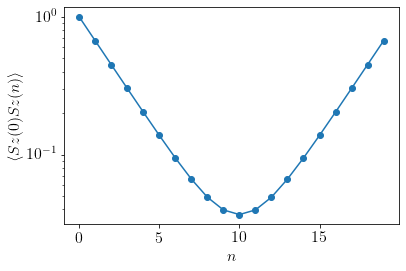

In [7]:
plt.plot(ts, corrs, "o-")
plt.yscale("log")
plt.xlabel("$n$")
plt.ylabel(r"$\left<Sz(0) Sz(n)\right>$")
#plt.plot(ts, np.exp(-2 * h * ts))

Do you understand the shape?

In [8]:
w, v = la.eigh(T)
w = w[::-1] #reverse ordering of eigenvalues 
v = v[:, ::-1]
print("eigenvalues", w)
#print("prediction", np.exp(-2*h) )
print("leading eigenvector", v[:,0])
O_eigen = v.T @ O @ v[:,0]
    

eigenvalues [1.   0.67]
leading eigenvector [0.707 0.707]


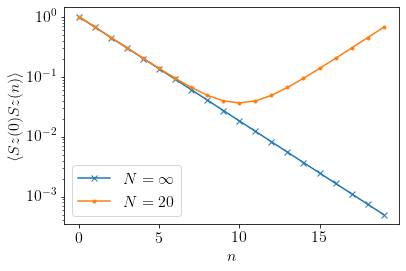

In [9]:
corr_infinity = np.array([(O_eigen[1] ** 2 * w[1] ** t) for t in ts])
plt.plot(ts, corr_infinity, "x-", label=r"$N = \infty$")
plt.plot(ts, corrs, ".-", label = r"$N = %d$" % N)
plt.yscale("log")

plt.xlabel("$n$")
plt.ylabel(r"$\left<Sz(0) Sz(n)\right>$")
plt.legend()

# 2D Ising model on a strip of width $L$

 The partition funtion $Z \propto (T_X T_Z)^N$ where $T_X$ is the tensor product of $L$ copies of 1D Ising model,  and 
 $$ T_Z = \prod_{j=1}^{L-1} \exp(J Z_j Z_{j+1}) $$
 We consider the transfer matrix $$ T = T_Z^{\frac12} T_X T_Z^{\frac12},  T_Z^{\frac12} = 
 \prod_{j=1}^{L-1} \exp(J/2 Z_j Z_{j+1})$$
 which has the advantage of being Hermitian. 

In [10]:

def add_one_site(TX, TZ_diag):
    """ add one site to the transfer matrices TX and TZ^(1/2),
    where TZ is represented by its diagonal elements."""
    TX = sp.kron(TX, sla.expm(X * h) / np.exp(h))
    TZ_diag = np.hstack([TZ_diag, TZ_diag])
    M = len(TZ_diag)//4
    TZ_diag[M:-M] *= np.exp(-J)
    return TX, TZ_diag
def onesite():
    """return the TX and TZ_diag of one site  """
    return sla.expm(X * h) / np.exp(h), np.array([1., 1.])

### understand the diagonal elements of $T_Z^{1/2}$ 

In [11]:
h = 1
J = .4
TX , TZ_diag = onesite()
for L in range(2, 4):
    TX, TZ_diag = add_one_site(TX, TZ_diag)
print("L=%d" % L) 
print("-" * L)
for j, val in enumerate(TZ_diag):
    print(format(j, "0%db" % L),"%g" % val)
print("exp(-nJ) = ", np.exp(-np.arange(4) * J))

L=3
---
000 1
001 0.67032
010 0.449329
011 0.67032
100 0.67032
101 0.449329
110 0.67032
111 1
exp(-nJ) =  [1.    0.67  0.449 0.301]


### the trivial paramagnet

In [12]:

h = 1
J = 0
TX , TZ_diag = onesite()
for L in range(2, 5):
    TX, TZ_diag = add_one_site(TX, TZ_diag)
print("L = ", L)
TZ = sp.diags(TZ_diag)
T =  TZ * TX * TZ
w, v = sla.eigsh(T, which = 'LM', k = 4)
if w[0] < w[-1]:
    w = w[::-1]
    v = v[:, ::-1]
print(w)

L =  4
[1.    0.135 0.135 0.135]


In [13]:
for j, val in enumerate(v[:, 0]):
    print(format(j, "04b"),"%.2f" % val)

0000 -0.25
0001 -0.25
0010 -0.25
0011 -0.25
0100 -0.25
0101 -0.25
0110 -0.25
0111 -0.25
1000 -0.25
1001 -0.25
1010 -0.25
1011 -0.25
1100 -0.25
1101 -0.25
1110 -0.25
1111 -0.25


### the trivial ferromagnet

In [14]:
# the trivial ferromagnet
h = 0
J = 1
TX , TZ_diag = onesite()
for L in range(2, 5):
    TX, TZ_diag = add_one_site(TX, TZ_diag)
print("L = ", L)
TZ = sp.diags(TZ_diag)
T =  TZ * TX * TZ
w, v = sla.eigsh(T, which = 'LM', k = 4)
if w[0] < w[-1]:
    w = w[::-1]
    v = v[:, ::-1]
print(w)

L =  4
[1.    1.    0.135 0.135]


In [15]:
for j, val in enumerate(v[:, 0]):
    print(format(j, "04b"),"%.2f" % val)
print("....................")
for j, val in enumerate(v[:, 1]):
    print(format(j, "04b"),"%.2f" % val)

0000 0.68
0001 0.00
0010 0.00
0011 -0.00
0100 -0.00
0101 -0.00
0110 -0.00
0111 -0.00
1000 0.00
1001 0.00
1010 -0.00
1011 -0.00
1100 0.00
1101 0.00
1110 -0.00
1111 0.74
....................
0000 -0.74
0001 -0.00
0010 -0.00
0011 0.00
0100 -0.00
0101 0.00
0110 -0.00
0111 0.00
1000 0.00
1001 0.00
1010 0.00
1011 0.00
1100 -0.00
1101 0.00
1110 -0.00
1111 0.68


### correlation length in the paramagnetic phase, up to the critical point
We will compute numerically the correlation length $\xi$ for various values of $J, h$ and system size. 
Argue that, in unit of the vertical lattice spacing, 
$$ \xi = - \ln (\lambda_1 / \lambda_0)  $$


In [16]:
res_length = dict()

In [17]:
# set a grid of Js
h = .1 # try with different h
Js = np.linspace(.5, 1., 20)

for Joverh in Js:
    J = h * Joverh
   # print(J)
    TX , TZ_diag = onesite()

    ws = []
    Ls = []
    xis = []
    for L in range(2,11):
        TX, TZ_diag = add_one_site(TX, TZ_diag)
        TZ = sp.diags(TZ_diag)
        #print("L = %d ... " % L, end = "")
        T =  TZ * TX * TZ

        w, v = sla.eigsh(T, k=2, which = "LM")
        length = -1 / np.log(w[0] / w[1])
        res_length[(h,J,L)] = length
    #print("")

Text(0, 0.5, '$\\xi$')

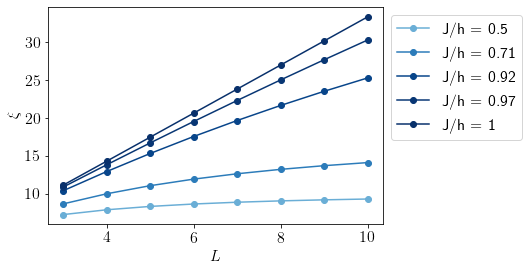

In [18]:

for Jappro in [.5, .7, .9, .95, 1.]:
    J = Js[np.searchsorted(Js, Jappro)]
    #if L < 7: continue
    Ls=np.arange(3, 11)
    xis = np.array([ res_length[(h, J* h, L)] for L in Ls ])
    
    plt.plot(Ls, xis, "o-", c=color(J / 1), label="J/h = %.2g" % J)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("$L$")
plt.ylabel(r"$\xi$" )

Text(0, 0.5, '$\\xi$')

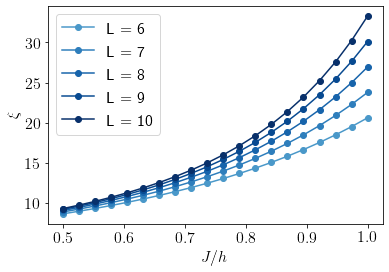

In [19]:
Ls = np.arange(6,11)
for L in Ls:
    #if L < 7: continue
    xis = np.array([ res_length[(h, J* h, L)] for J in Js if J])
    
    plt.plot(Js, xis, "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel("$J/h$")
plt.ylabel(r"$\xi$" )

Text(0, 0.5, '$\\xi / L$')

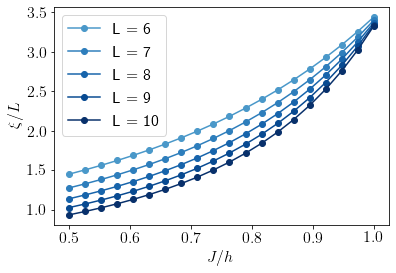

In [20]:

Ls = np.arange(6,11)
for L in Ls:
    #if L < 7: continue
    xis = np.array([ res_length[(h, J* h, L)] for J in Js if J])
    
    plt.plot(Js, xis / L, "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel("$J/h$")
plt.ylabel(r"$\xi / L$" )

The critical scaling: the distance to the critical point $t$ is amplified by the system size (here $L$), usually in a power law fashion $t \to t L^{\nu}$, where $\nu$ is the correlation length exponent. 
For the 2D Ising critical point, we know $\nu = 1$ by its exact solution (we will show this in a later TD).
Here we shall see how this works in our baby numerics.

Text(0, 0.5, '$\\xi / L$')

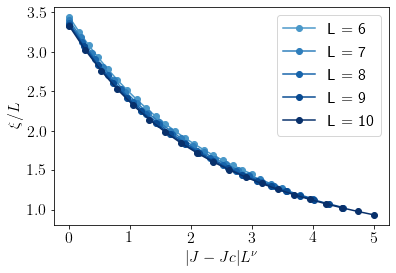

In [28]:
h = .1
Ls = np.arange(6,11)
for L in Ls:
    #if L < 7: continue
    xis = np.array([ res_length[(h, J* h, L)] for J in Js if J])
    
    plt.plot((1-Js) * L, xis / L, "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel(r"$|J-Jc| L^{\nu}$")
plt.ylabel(r"$\xi / L$" )

In the above plot, can we understand/justify the choice of the y axis? 

## Transverse field Ising model
One observation from the critical scaling is that it works much better when $h$ and $J$ are small. 
In the limit $h, J \to h \delta t, J \delta t$, the transfer matrix becomes $cI - H \delta t + O((\delta t)^2)$, where
$$ H =  - \sum_{j=1}^L h X_j -   \sum_{j=1}^{L-1}J Z_j Z_{j+1}$$
is the famous transverse field Ising model (TFIM). 

In [22]:
def get_Ising_terms():
    Xs = sum([sp.kron(np.identity(2 ** (L-j-1)), sp.kron(X, np.identity(2 ** j)) ) for j in range(L)])
    ZZ = sp.kron(Z, Z)
    ZZs = sum([sp.kron(np.identity(2 ** (L-j-2)), sp.kron(ZZ, np.identity(2 ** j)) ) for j in range(L-1)])
    return Xs, ZZs

In [23]:
res_len_Q = dict()

In [24]:
#redo the critical scaling with TFIM
Js = np.linspace(.5, 1., 20)
for L in range(7, 14):
    print(".",end="")
    Xs, ZZs = get_Ising_terms()
    for J in Js:
        H = -Xs - ZZs * J
        w,v= sla.eigsh(H, which = "SA", k = 2)
        length = 1/abs(w[1] - w[0])
        res_len_Q[(J,L)] = length


.......

Text(0, 0.5, '$\\xi / L$')

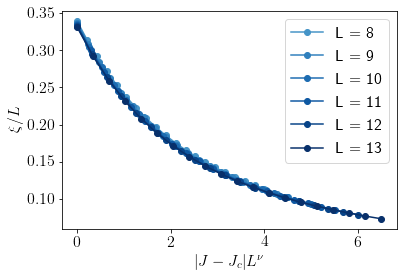

In [27]:
Ls = np.arange(8,14)
for L in Ls:
    #if L < 7: continue
    xis = np.array([ res_len_Q[(J, L)] for J in Js])
    
    plt.plot((1-Js) * L, xis / L, "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel(r"$|J-J_c| L^{\nu}$")
plt.ylabel(r"$\xi / L$" )

## the ferromagnetic phase


In [46]:
J = 2
gap = []
gap1 = []
Ls = np.arange(3,13)
for L in Ls:
    print(".",end="")
    Xs, ZZs = get_Ising_terms()
    H = -Xs - ZZs * J
    w,v= sla.eigsh(H, which = "SA", k = 3)
    gap.append((w[1] - w[0]))
    gap1.append((w[2] - w[1]))

..........

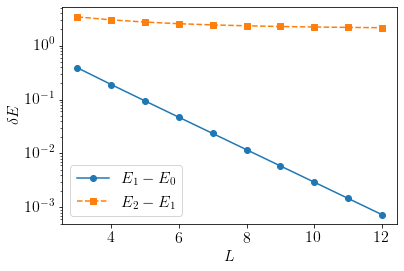

In [43]:
plt.plot(Ls, gap, "o-",label="$E_1-E_0$")
plt.plot(Ls, gap1,"s--", label="$E_2-E_1$")
#plt.plot(Ls, gap1)
plt.yscale("log")
plt.xlabel("$L$")
plt.ylabel("$\delta E$")
plt.legend()

The two lowest states are degenerate in the thermodynamic limit. For finite systems, their gap is exponential small. 
- Can we understand the exponential-in-$L$ gap from perturbing the $J \gg h$ limit? 
- Physically what does this degeneracy relate to?

### computing the ``spontaneous magnetization''

The following code looks at the matrix elements of a spin operator in the degenerate ground state manifold.
Do we understand the output? 


In [48]:
J = 1.5
L = 6
Xs, ZZs = get_Ising_terms()
# Sz measures the magnetization of the middle spin
Sz = sp.kron(np.identity(2 ** (L-L//2-1)), sp.kron(Z, np.identity(2 ** (L // 2))) )
H = -Xs - ZZs * J
w,v= sla.eigsh(H, which = "SA", k = 2)
Sz_deg = v.T @ Sz @ v
print(Sz_deg)

[[-0.    -0.915]
 [-0.915  0.   ]]


We now exploit this to calculate the "spontaneous magnetization" of finite systems (which does not exist *stricto sensu*)

In [34]:
res_magnet = dict()

In [35]:
Js = np.linspace(1., 1.2, 15)
Ls = np.arange(3,14,2)

for L in Ls:
    
    Xs, ZZs = get_Ising_terms()
    Sz = sp.kron(np.identity(2 ** (L-L//2-1)), sp.kron(Z, np.identity(2 ** (L // 2))) )
    for J in Js:
        H = -Xs - ZZs * J
        w,v= sla.eigsh(H, which = "SA", k = 2)
        Sz_deg = v.T @ Sz @ v
        M = la.eigvalsh(Sz_deg)[-1]
        res_magnet[J, L] = M
        print(".",end="")

..........................................................................................

Text(0, 0.5, '$M$')

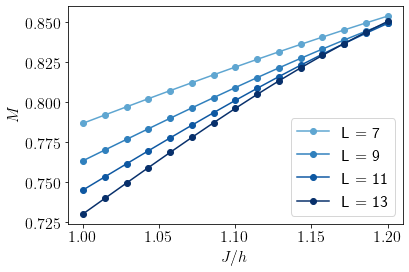

In [37]:
for L in Ls:
    if L < 7 or L % 2 == 0: continue
    Ms = np.array([ res_magnet[J, L] for J in Js])
    
    plt.plot(Js, Ms, "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel("$J/h$")
plt.ylabel("$M$")

To do the critical scaling of this observable, we need to know another exponent, 
the scaling dimension of the spin operator $\Delta_{\sigma} = 1/8$. 
It implies that $L^{\Delta_\sigma} m$ should be viewed as dimensionless in a critical scaling. Here is how it works.

Text(0, 0.5, '$M L^{\\Delta_{\\sigma}}$')

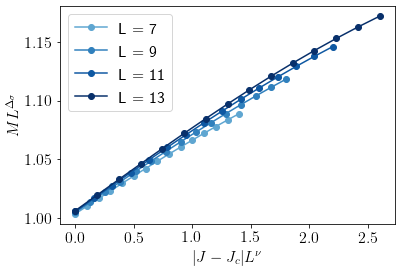

In [41]:
for L in Ls:
    if L < 7 or L % 2 == 0: continue
    Ms = np.array([ res_magnet[J, L] for J in Js])
    plt.plot((Js - 1) * L, Ms * L ** 0.125 , "o-", c=color(L / Ls[-1]), label="L = %d" % L)
plt.legend()
plt.xlabel(r"$|J-J_c|L^{\nu}$")
plt.ylabel(r"$M L^{\Delta_{\sigma}}$")